# Bayesian Time Series Analysis of Spotify Listening Time per Day

## Set up 

In [15]:
# general pkgs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# model pkgs
import pymc
import arviz as az
# assumption pkg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm


# Load the prepared data
spot = pd.read_csv('spot_day_data.csv')

spot = spot[['date', 'minutes_listened']]

spot['date'] = pd.to_datetime(spot['date'])  # Ensure 'date' column is datetime format
spot.set_index('date', inplace=True)  # Set 'date' column as index


## Model Specifications

Proceeding with a bayesian autoregressive model of order 1.

### Parameters

 This model consists of 3 parameters: autoregressive coefficient, error term(white noise)

1. **Local level model**: Determines the central tendency of the series. It has one parameter: \( u_t \).
2. **Local linear trend**: Determines the trend of the series. It has two parameters: \( u_t \) (level) and \( v_t \) (slope, which is the rate of change of the level).
3. **Seasonal effect**: Determines the magnitude and pattern of the series. It has one parameter: \( s_t \).

where:
- \( y_t \) is the observed value at time \( t \),  
- \( u_t \) is the local level at time \( t \), 
- \( v_t \) is the local linear trend at time \( t \),  

### Model Assumptions

1. **Stationary -** time series should have the same mean, variance, and autocorr over time
2. **White Noise -** the errors have a mean of 0, equal var, and not autocorrelated


## Checking Assumptions

### Stationarity Check

In [16]:
# stationarity check
# Assuming your time series is in a variable named 'series'
result = adfuller(spot['minutes_listened'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

ADF Statistic: -5.1113968709709345
p-value: 1.3297803599857623e-05
Critical Values:
1%: -3.4491725955218655
5%: -2.8698334971428574
10%: -2.5711883591836733


We meet the assumption of stationary, because we rejected (pval = 1.3e-05) the null hypothesis for the nonstationary test and the ADF stat is less the all the critical values

### White Noise Check

/home/arrowboy/Documents/School/Spring2024/Stat415/project/myenv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


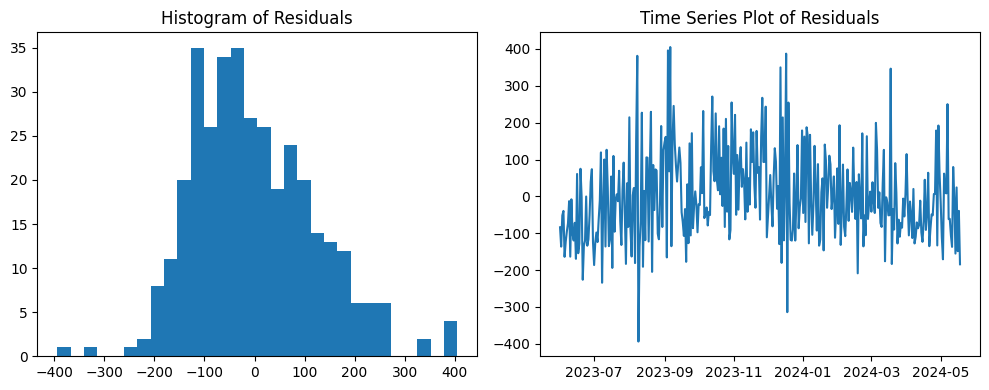

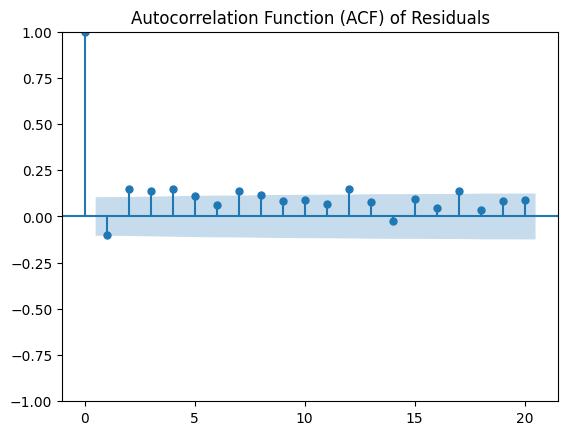

In [17]:
# Fit AR(1) model
# taking log of the data
model = AutoReg(spot['minutes_listened'], lags=1)
results = model.fit()

# Get residuals
residuals = results.resid


# Plot residuals
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.subplot(1, 2, 2)
plt.plot(residuals)
plt.title('Time Series Plot of Residuals')
plt.tight_layout()
plt.show()

# Plot ACF of residuals
plot_acf(residuals, lags=20)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.show()


The error residuals (white noise) assumptions are satisfied

- normality: appear to be approximetly normally distributed (there is a kinda heavy tail, but mostly normal)
- equal var: they seem to be pretty random and consistantly vary
- independence: only 1 extreme autocorr(not gr8, but prob fine)

## Prior Distrib and Prior Pred

$$
u_t \sim \mathcal{N}(0, 10),    
v_t \sim \mathcal{N}(0.5, 1),   
s_t \sim \mathcal{N}(0, 1),     
$$  

In [1]:

def draw_from_samples(samples):

    AR1_model = pm.Model()

    with AR1_model:
        

SyntaxError: incomplete input (2949948992.py, line 11)

## Posterior Calculation

In [ ]:
def draw_from_posterior(sample):
    """
    Draw a sample of size N from the posterior distribution.
    """

    AR1_model = pmc.Model()

    with AR1_model:
        
        # Start with priors
        rho = pmc.Uniform('rho',lower=-1.,upper=1.)  # Assume stable rho
        sigma = pmc.HalfNormal('sigma', sigma = np.sqrt(10))

        # Expected value of y at the next period (rho * y)
        yhat = rho * sample[:-1]

        # Likelihood of the actual realization.
        y_like = pmc.Normal('y_obs', mu=yhat, sigma=sigma, observed=sample[1:])

    with AR1_model:
        trace = pmc.sample(10000, tune=5000)

    # check condition
    with AR1_model:
        az.plot_trace(trace, figsize=(17, 6))
    
    rhos = trace.posterior.rho.values.flatten()
    sigmas = trace.posterior.sigma.values.flatten()

    post_sample = {
        'rho': rhos,
        'sigma': sigmas
    }
    
    return post_sample

post_samples = draw_from_posterior(initial_path)

## Posterior Prediction and Interpretation